# A simple Client Credit Rating Model (Logistic Regression)

https://www.kaggle.com/datasets/satyajeetrai/credit-risk-dataset/data

Released under MIT License

Copyright (c) 2013 Mark Otto.

Copyright (c) 2017 Andrew Fong.

### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

### Load from S3 Bucket

In [2]:
from google.cloud import bigquery

# This works out of the box on Vertex AI Workbench
client = bigquery.Client()

# Run a query
query = """
SELECT * FROM `credit-risk-459910.CreditData.csv`
LIMIT 1001
"""
df = client.query(query).to_dataframe()
df.head()

,id,Duration in months,Credit history,Purpose of the credit,Credit amount,Status of savings account_bonds,Present employment_years_,Installment rate in percentage of disposable income,personal_status,Other debtors _ guarantors,...,Property,Age in years,Other installment plans _banks_stores_,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Status of existing checking account
0,634,9,existing paid,furniture/equipment,1980,<100,<1,2,female div/dep/mar,co applicant,...,car,19,none,rent,2,skilled,1,none,True,bad
1,156,12,existing paid,furniture/equipment,1282,<100,1<=X<4,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,bad
2,297,12,existing paid,used car,4675,no known savings,<1,1,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,good
3,411,24,existing paid,radio/tv,1967,<100,>=7,4,female div/dep/mar,none,...,car,20,none,own,1,skilled,1,yes,True,good
4,421,15,existing paid,new car,3186,>=1000,4<=X<7,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,good


### Remove unuseful variables

In [3]:
df = df.drop(['id','Purpose of the credit','Other debtors _ guarantors','Number of people being liable to provide maintenance for'], axis=1)

### Prepare Data

In [4]:
# Target setup
target_column = 'Status of existing checking account'
df[target_column] = df[target_column].map({'good': 1, 'bad': 0})
X = df.drop(columns=[target_column])
y = df[target_column]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.1, random_state=42)

# Column types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Transform
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
print(X_train_proc)

[[ 0.23837095  0.3276784  -1.73875784 ...  1.          0.
   1.        ]
 [ 1.93588828 -0.50762105  0.93017119 ...  0.          0.
   1.        ]
 [ 1.20838085 -0.40303431 -0.84911483 ...  0.          0.
   1.        ]
 ...
 [-0.00413152 -0.18096179 -1.73875784 ...  0.          1.
   0.        ]
 [-0.73163895 -0.62684993  0.93017119 ...  0.          1.
   0.        ]
 [-0.00413152 -0.13180602 -1.73875784 ...  0.          0.
   1.        ]]


### Run Logistic Regression Model

In [5]:
# Model: Logistic Regression with class balancing
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_proc, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test_proc)[:, 1]

# Threshold tuning
threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)

f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Print Results
print("\nEVALUATION METRICS")
print("=" * 50)
print(f"Threshold: {threshold}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['bad', 'good']))


EVALUATION METRICS
Threshold: 0.4
ROC AUC: 0.6390

Classification Report:
              precision    recall  f1-score   support

         bad       0.40      0.33      0.36        30
        good       0.73      0.79      0.76        70

    accuracy                           0.65       100
   macro avg       0.57      0.56      0.56       100
weighted avg       0.63      0.65      0.64       100



### Show Confusion Matrx

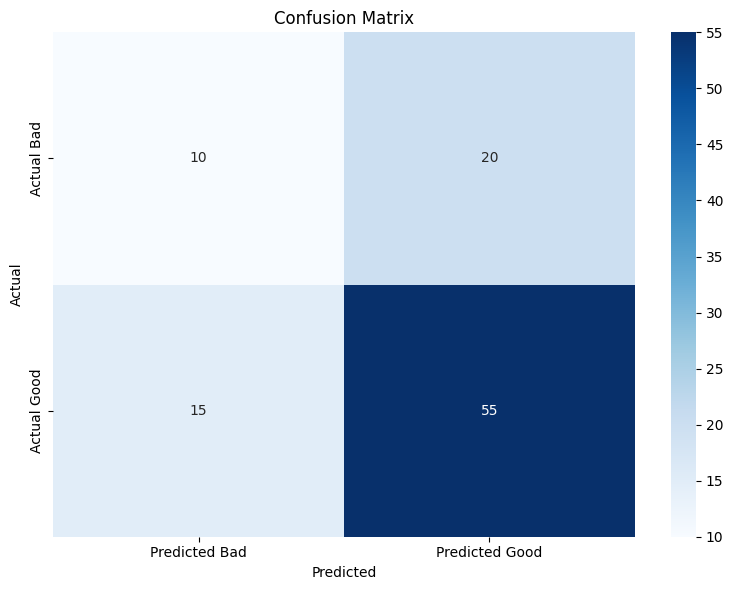

In [6]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Show ROC Curve

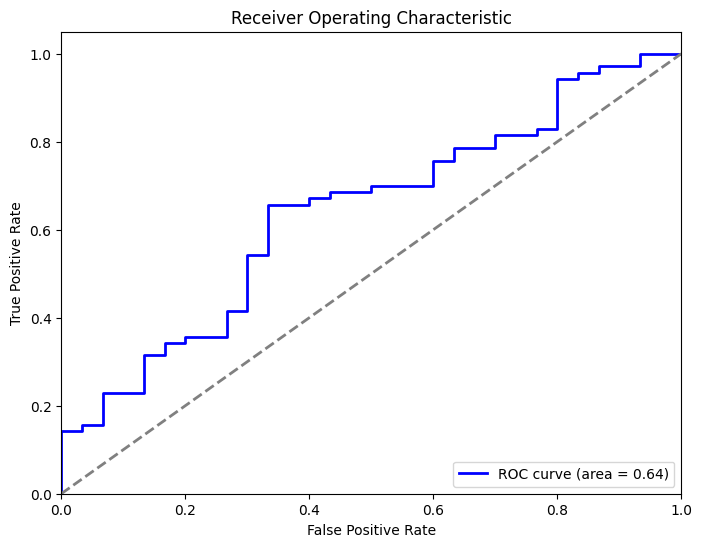

ROC AUC: 0.6390


In [7]:
# ROC curve
if auc is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

### Analyse Most Important Predictors

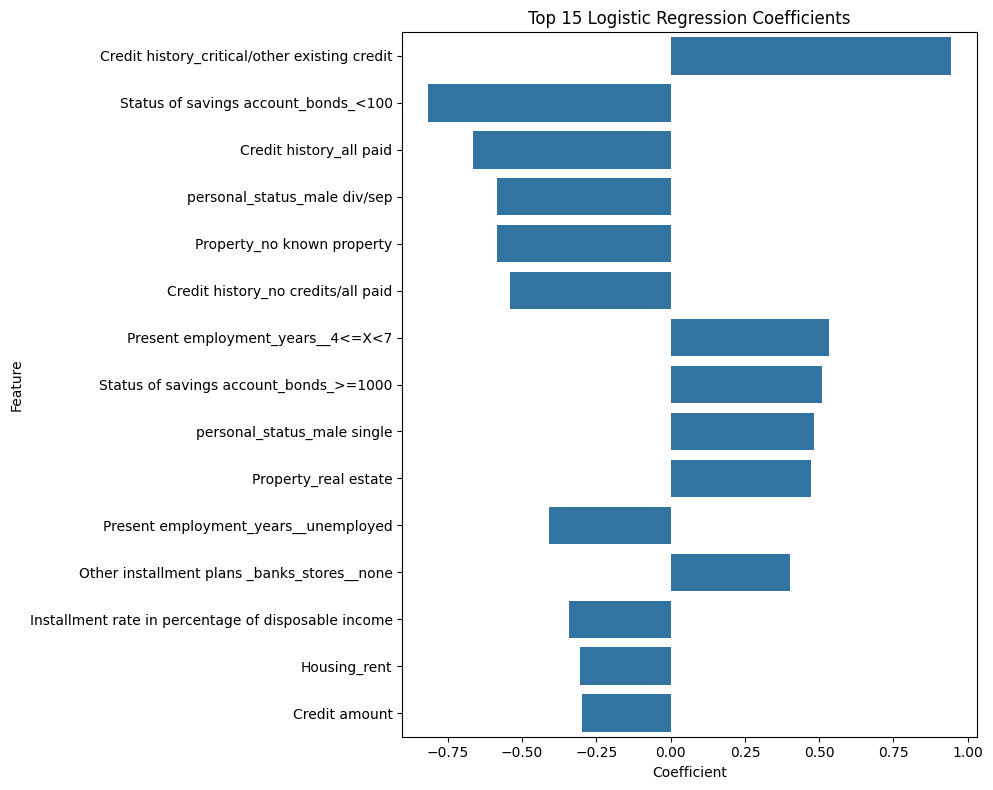

In [8]:
# Feature Importance (coefficients)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)
coefficients = model.coef_[0]

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

### Conclusions

As Expected the main problem of our model is the low recall for the "bad" credit class. Which, by the way, is the most impactful when we are concerned with credit risk as most of our losses will come from the uncovered accounts form bad credit and not the lost opportunities from the missclassified instancies of the "good" credit class. We will later try some different ML algorithms to achive better results